# Use MVTec AD Dataset via API

# Installing Anomalib

The easiest way to install anomalib is to use pip. You can install it from the command line using the following command:


In [ ]:
%pip install anomalib

In [1]:
# flake8: noqa
import numpy as np
from PIL import Image
from torchvision.transforms.v2 import Resize
from torchvision.transforms.v2.functional import to_pil_image

from anomalib.data.image.mvtec import MVTec, MVTecDataset
from anomalib import TaskType

## Setting up the Dataset Directory

This cell is to ensure we change the directory to have access to the datasets.


In [2]:
from pathlib import Path

# NOTE: Provide the path to the dataset root directory.
#   If the datasets is not downloaded, it will be downloaded
#   to this directory.
dataset_root = Path.cwd().parent / "datasets" / "MVTec"

### DataModule

Anomalib data modules are based on PyTorch Lightning (PL)'s `LightningDataModule` class. This class handles all the boilerplate code related to subset splitting, and creating the dataset and dataloader instances. A datamodule instance can be directly passed to a PL Trainer which is responsible for carrying out Anomalib's training/testing/inference pipelines.

In the current example, we will show how an Anomalib data module can be created for the MVTec Dataset, and how we can obtain training and testing dataloaders from it.

To create a datamodule, we simply pass the path to the root folder of the dataset on the file system, together with some basic parameters related to pre-processing and image loading:


In [3]:
mvtec_datamodule = MVTec(
    root=dataset_root,
    category="bottle",
    image_size=256,
    train_batch_size=32,
    eval_batch_size=32,
    num_workers=0,
    task=TaskType.SEGMENTATION,
)

For the illustrative purposes of the current example, we need to manually call the `prepare_data` and `setup` methods. Normally it is not necessary to call these methods explicitly, as the PL Trainer would call these automatically under the hood.

`prepare_data` checks if the dataset files can be found at the specified file system location. If not, it will download the dataset and place it in the folder.

`setup` applies the subset splitting and prepares the PyTorch dataset objects for each of the train/val/test subsets.


In [4]:
mvtec_datamodule.prepare_data()
mvtec_datamodule.setup()

After the datamodule has been set up, we can use it to obtain the dataloaders of the different subsets.


In [5]:
# Train images
i, data = next(enumerate(mvtec_datamodule.train_dataloader()))
print(data.keys(), data["image"].shape)

dict_keys(['image_path', 'label', 'image', 'mask']) torch.Size([32, 3, 900, 900])


In [6]:
# Test images
i, data = next(enumerate(mvtec_datamodule.test_dataloader()))
print(data.keys(), data["image"].shape, data["mask"].shape)

dict_keys(['image_path', 'label', 'image', 'mask']) torch.Size([32, 3, 900, 900]) torch.Size([32, 900, 900])


As can be seen above, creating the dataloaders are pretty straghtforward, which could be directly used for training/testing/inference. We could visualize samples from the dataloaders as well.


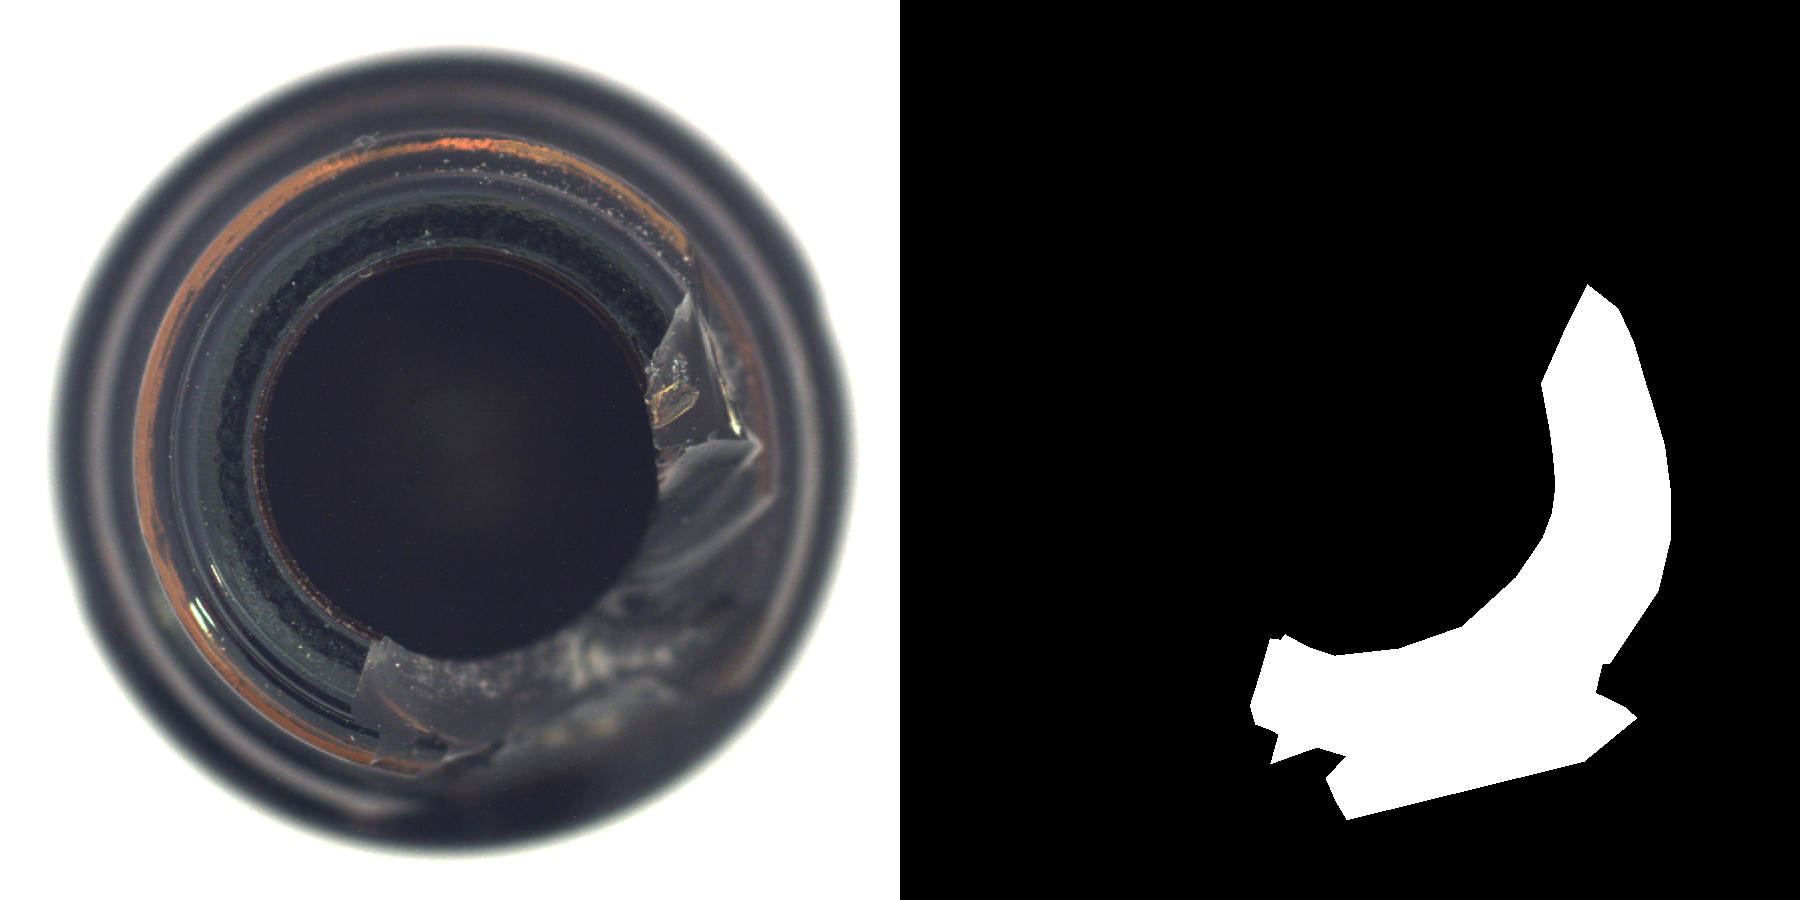

In [7]:
img = to_pil_image(data["image"][0].clone())
msk = to_pil_image(data["mask"][0]).convert("RGB")

Image.fromarray(np.hstack((np.array(img), np.array(msk))))

### Torch Dataset

In some cases it might be desirable to create a standalone PyTorch dataset without a PL data module. For example, this could be useful for training a PyTorch model outside Anomalib, so without the use of a PL Trainer instance. In such cases, the PyTorch Dataset instance can be instantiated directly.


In [ ]:
MVTecDataset??

We can add some transforms that will be applied to the images using torchvision. Let's add a transform that resizes the 
input image to 256x256 pixels.

In [8]:
image_size = (256, 256)
transform = Resize(image_size, antialias=True)

#### Classification Task


In [9]:
# MVTec Classification Train Set
mvtec_dataset_classification_train = MVTecDataset(
    root=dataset_root,
    category="bottle",
    transform=transform,
    split="train",
    task="classification",
)
mvtec_dataset_classification_train.samples.head()

,path,split,label,image_path,label_index,mask_path
0,/home/djameln/datasets/MVTec/bottle,train,good,/home/djameln/datasets/MVTec/bottle/train/good...,0,
1,/home/djameln/datasets/MVTec/bottle,train,good,/home/djameln/datasets/MVTec/bottle/train/good...,0,
2,/home/djameln/datasets/MVTec/bottle,train,good,/home/djameln/datasets/MVTec/bottle/train/good...,0,
3,/home/djameln/datasets/MVTec/bottle,train,good,/home/djameln/datasets/MVTec/bottle/train/good...,0,
4,/home/djameln/datasets/MVTec/bottle,train,good,/home/djameln/datasets/MVTec/bottle/train/good...,0,


In [10]:
sample = mvtec_dataset_classification_train[0]
print(sample.keys(), sample["image"].shape)

dict_keys(['image_path', 'label', 'image']) torch.Size([3, 256, 256])


As can be seen above, when we choose `classification` task and `train` split, the dataset only returns `image`. This is mainly because training only requires normal images and no labels. Now let's try `test` split for the `classification` task


In [11]:
# MVTec Classification Test Set
mvtec_dataset_classification_test = MVTecDataset(
    root=dataset_root,
    category="bottle",
    transform=transform,
    split="test",
    task="classification",
)
sample = mvtec_dataset_classification_test[0]
print(sample.keys(), sample["image"].shape, sample["image_path"], sample["label"])

dict_keys(['image_path', 'label', 'image']) torch.Size([3, 256, 256]) /home/djameln/datasets/MVTec/bottle/test/broken_large/000.png 1


#### Segmentation Task

It is also possible to configure the MVTec dataset for the segmentation task, where the dataset object returns image and ground-truth mask.


In [12]:
# MVTec Segmentation Train Set
mvtec_dataset_segmentation_train = MVTecDataset(
    root=dataset_root,
    category="bottle",
    transform=transform,
    split="train",
    task="segmentation",
)
mvtec_dataset_segmentation_train.samples.head()

,path,split,label,image_path,label_index,mask_path
0,/home/djameln/datasets/MVTec/bottle,train,good,/home/djameln/datasets/MVTec/bottle/train/good...,0,
1,/home/djameln/datasets/MVTec/bottle,train,good,/home/djameln/datasets/MVTec/bottle/train/good...,0,
2,/home/djameln/datasets/MVTec/bottle,train,good,/home/djameln/datasets/MVTec/bottle/train/good...,0,
3,/home/djameln/datasets/MVTec/bottle,train,good,/home/djameln/datasets/MVTec/bottle/train/good...,0,
4,/home/djameln/datasets/MVTec/bottle,train,good,/home/djameln/datasets/MVTec/bottle/train/good...,0,


In [13]:
# MVTec Segmentation Test Set
mvtec_dataset_segmentation_test = MVTecDataset(
    root=dataset_root,
    category="bottle",
    transform=transform,
    split="test",
    task="segmentation",
)
sample = mvtec_dataset_segmentation_test[20]
print(sample.keys(), sample["image"].shape, sample["mask"].shape)

dict_keys(['image_path', 'label', 'image', 'mask']) torch.Size([3, 256, 256]) torch.Size([256, 256])


Let's visualize the image and the mask...


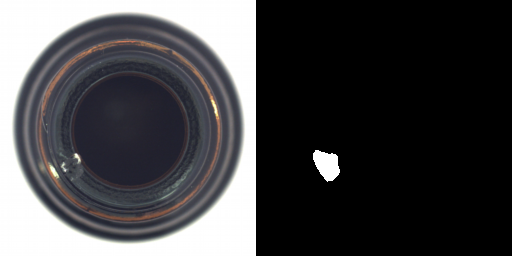

In [14]:
img = to_pil_image(sample["image"].clone())
msk = to_pil_image(sample["mask"]).convert("RGB")

Image.fromarray(np.hstack((np.array(img), np.array(msk))))